In [237]:
import time
from collections import defaultdict
import json
import math
import random
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
print(sklearn.__version__)
import shap

1.0.2


In [236]:
# fig = plt.figure(figsize=(4, 2))
# ax = plt.gca()
# ax.text(.15, .6, "Unicode minus:", fontsize=20)
# ax.text(.85, .6, "\N{MINUS SIGN}1", ha='right', fontsize=20)
# ax.text(.15, .3, "ASCII hyphen:", fontsize=20)
# ax.text(.85, .3, "-1", ha='right', fontsize=20)
# # fig
# plt.savefig('../reports/figures/Figure6/SHAP_waterfall_plots/'
#                 f'rat{animal_label}_{idx%3 + 1}_waterfall_test.pdf', 
#                 dpi=300, bbox_inches='tight')

In [57]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

In [158]:
fg['lipid_run_order'].to_clip

combined_col_name
1091_8_RBG     18
1091_9_RBG     32
1091_10_RBG    24
1093_8_RBG     61
1093_9_RBG     28
1093_10_RBG    13
1060_8_RBG     10
1060_9_RBG     15
1060_10_RBG    53
1062_8_RBG     59
1062_9_RBG     63
1062_10_RBG    17
1074_8_RBG     35
1074_9_RBG     31
1074_10_RBG    42
1092_8_RBG     65
1092_9_RBG     12
1092_10_RBG    66
1102_8_RBG     41
1102_9_RBG     48
1102_10_RBG    36
1076_8_RBG     26
1076_9_RBG     38
1076_10_RBG    45
1082_8_RBG     58
1082_9_RBG     44
1082_10_RBG    30
1101_8_RBG     64
1101_9_RBG     55
1101_10_RBG    20
Name: lipid_run_order, dtype: int64

# Drop all fasted data

In [60]:
fg = fg.loc[fg['bg_type'] == 'RBG']
data_cols = data.filter(regex='_RBG').columns

In [61]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)
X_id = X_scaled.loc[:, data.loc[data['ID'] != 'Unidentified'].index]

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

In [156]:
ap.columns

Index(['Nile rat label', 'Date of birth', 'litter', 'lcms_sampled',
       'glucose_tolerance', 'OGTT(0min)', 'OGTT(10min)', 'OGTT(20min)',
       'OGTT(30min)', 'OGTT(60min)', 'OGTT(120min)', 'OGTT (AUC)',
       'Insulin(0min)', 'Insulin(10min)', 'Insulin(20min)', 'Insulin(30min)',
       'Insulin(60min)', 'Insulin(120min)', 'Insulin (AUC)', 'RBGweek4',
       'RBGweek8', 'RBGweek9', 'RBGweek10', 'RBGweek11', 'RBGweek12',
       'FBGweek8', 'FBGweek9', 'FBGweek10', 'FBGweek11', 'FBGweek12',
       'InsulinFBGweek8', 'InsulinFBGweek9', 'InsulinFBGweek10',
       'InsulinFBGweek11', 'InsulinFBGweek12', 'InsulinRBGweek8',
       'InsulinRBGweek9', 'InsulinRBGweek10', 'InsulinRBGweek11',
       'InsulinRBGweek12', 'WeightRBGweek4', 'WeightRBGweek8',
       'WeightRBGweek9', 'WeightRBGweek10', 'WeightRBGweek11',
       'WeightRBGweek12', 'WeightFBGweek8', 'WeightFBGweek9',
       'WeightFBGweek10', 'WeightFBGweek11', 'WeightFBGweek12',
       'Weightprefastweek8', 'Weightprefastweek9', 'W

# Use the top ten features as chosen by Elastic net

In [152]:
top_feats = ['l_844', 'l_186', 'l_505', 'l_134', 'l_164', 'm_128', 'l_569', 'l_582', 'l_435', 'l_648']
top_feat_ids = data.loc[top_feats, 'ID'].values
X_top = X_scaled.loc[:, top_feats]
X_top.columns = data.loc[top_feats, 'ID']
X_top

ID,CE 18:1,PC 38:7,Plasmanyl-PC O-20:0_20:4,FA 18:0,PC 36:3,4-Guanidinobutyric acid,TG 20:5_22:6_22:6,TG 22:6_22:6_22:6,SM d37:1,TG 18:1_22:6_22:6
1091_8_RBG,1.253722,1.361736,-1.905354,1.798475,-1.753271,0.072772,-0.634662,-1.003884,-1.777168,-1.276748
1091_9_RBG,2.070967,0.968465,-0.686174,0.241529,-1.072182,-0.603835,-1.264310,-0.823708,-1.736699,-1.136550
1091_10_RBG,-1.305254,-0.515952,-2.258745,-0.361158,-2.326579,-0.901904,-1.497714,-1.978233,-2.439985,-2.359617
1093_8_RBG,0.837032,0.964748,-2.344555,-1.930927,-0.504121,-0.619709,-1.136374,-1.201685,-0.868292,-1.097436
1093_9_RBG,1.587654,0.659067,-0.930841,1.246665,-0.121620,-1.306238,0.257200,-0.163375,-1.477545,0.250159
1093_10_RBG,1.871955,1.026320,-0.822656,0.422917,-1.445754,-0.794676,-0.566562,-0.712111,-0.390991,-0.419000
1060_8_RBG,-0.957253,-0.254260,-0.393220,-0.863973,0.284843,1.579439,0.847298,0.690921,-0.337514,0.798781
1060_9_RBG,-0.054852,0.263117,0.389424,-0.496819,1.587125,0.707380,0.753574,0.641362,1.262142,0.994283
1060_10_RBG,-1.639534,1.453806,0.146743,-1.224606,-1.170886,0.152842,0.849495,0.702319,0.181762,0.934415
1062_8_RBG,-0.197813,0.414470,-0.075565,-0.087504,-0.546630,0.069315,1.064149,0.926157,0.821801,0.869916


In [153]:
top_feat_ids

array(['CE 18:1', 'PC 38:7', 'Plasmanyl-PC O-20:0_20:4', 'FA 18:0',
       'PC 36:3', '4-Guanidinobutyric acid', 'TG 20:5_22:6_22:6',
       'TG 22:6_22:6_22:6', 'SM d37:1', 'TG 18:1_22:6_22:6'], dtype=object)

In [84]:
ols = LinearRegression().fit(X_top, y_ogtt)

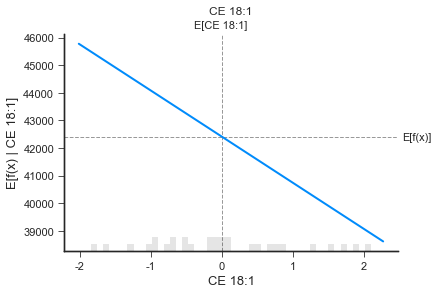

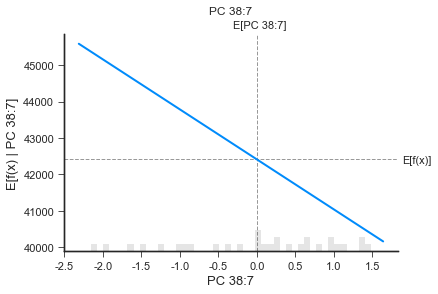

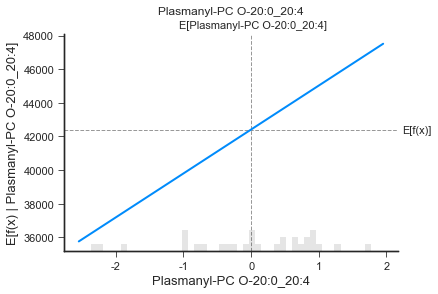

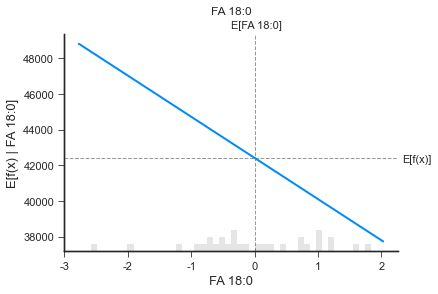

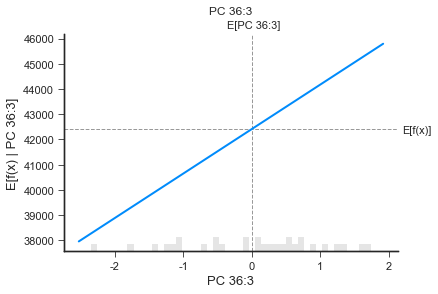

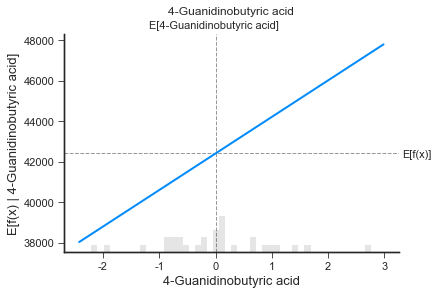

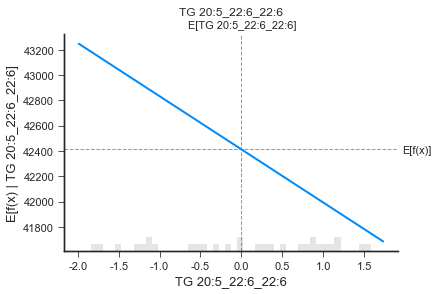

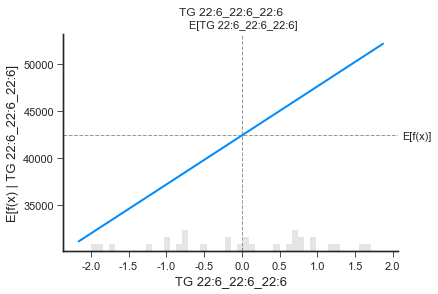

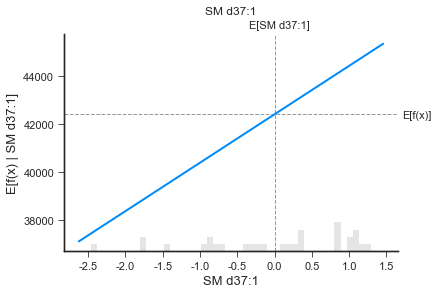

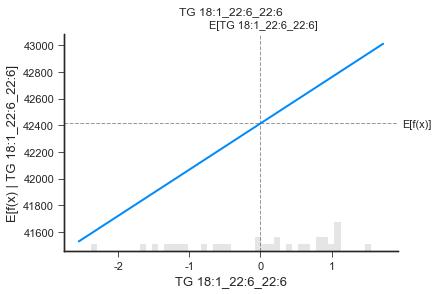

In [87]:
# fig, axs = plt.subplots(nrows=5, ncols=2, dpi=100, figsize=(4, 6), sharey=True)
for feature in X_top.columns:
    shap.partial_dependence_plot(
        feature, ols.predict, X_top, ice=False, 
        model_expected_value=True, feature_expected_value=True, show=False)
#     plt.gca().set_title(data.loc[feature, 'ID'])
    plt.gca().set_title(feature)

In [88]:
explainer = shap.Explainer(ols.predict, X_top)
shap_values = explainer(X_top)

In [243]:
for idx in range(len(y_ogtt)):
    ogtt_value = y_ogtt.iloc[idx]
    animal_label = ap.loc[ap['OGTT (AUC)'] == ogtt_value, 'Nile rat label'].values[0]
    

0 A 1
1 A 2
2 A 3
3 B 1
4 B 2
5 B 3
6 G 1
7 G 2
8 G 3
9 E 1
10 E 2
11 E 3
12 D 1
13 D 2
14 D 3
15 C 1
16 C 2
17 C 3
18 F 1
19 F 2
20 F 3
21 J 1
22 J 2
23 J 3
24 I 1
25 I 2
26 I 3
27 H 1
28 H 2
29 H 3


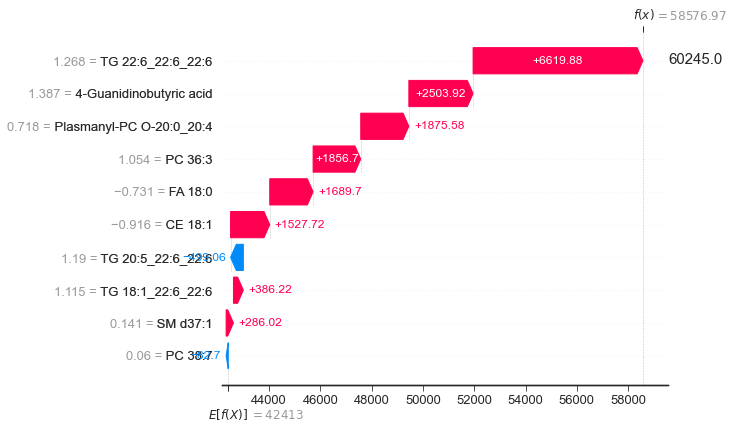

In [253]:
wf

2 A 3
20 F 3
23 J 3


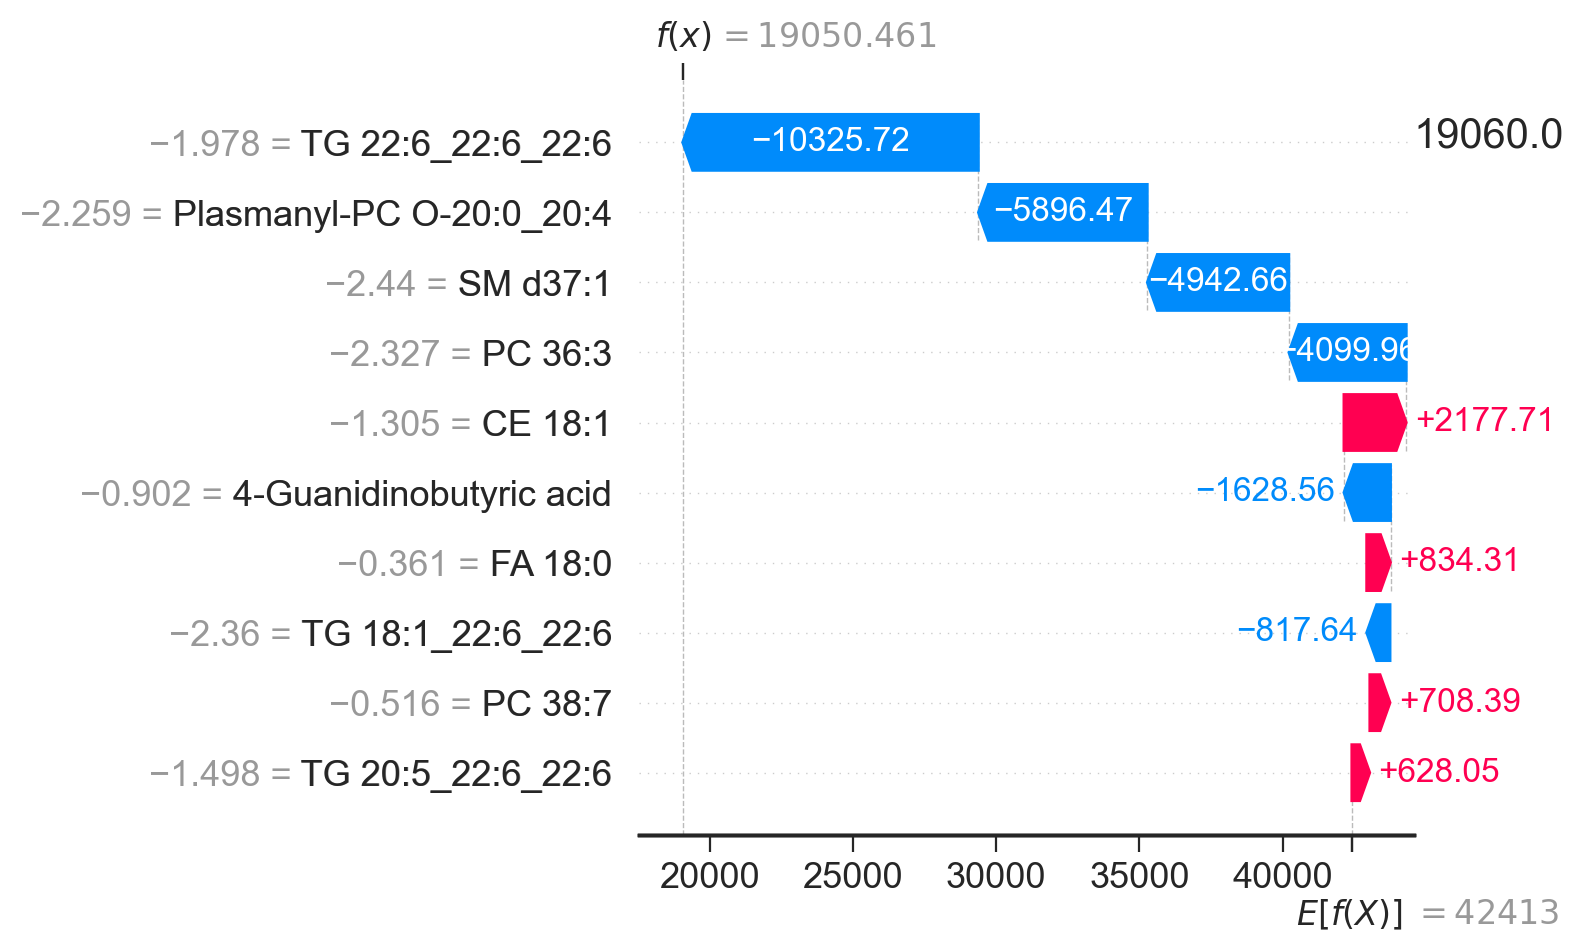

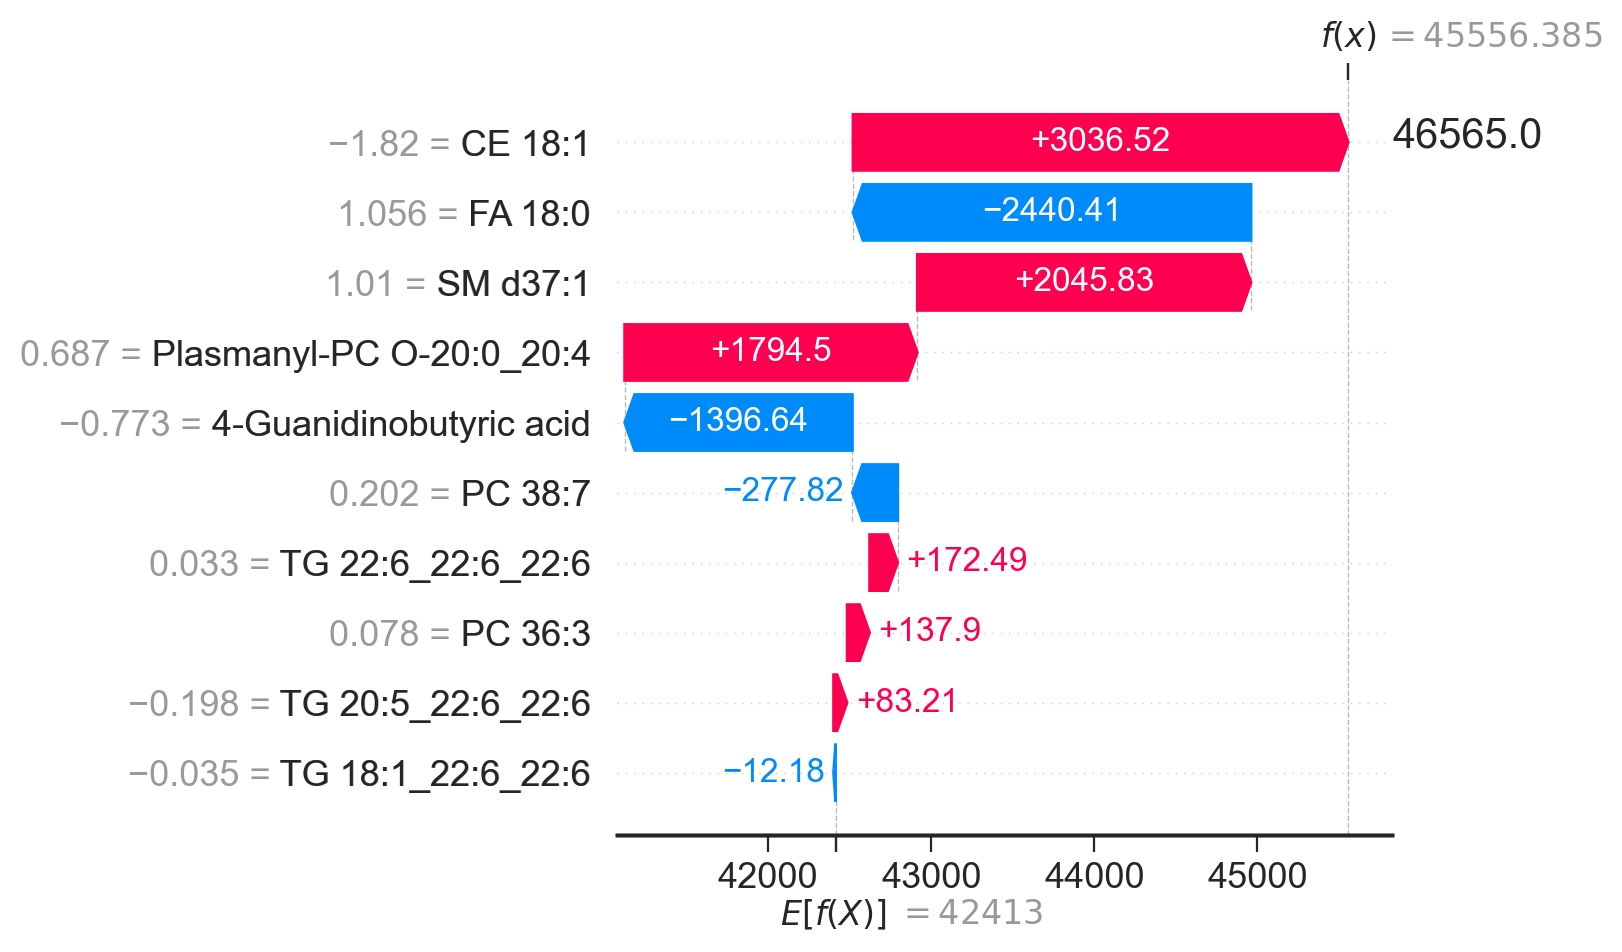

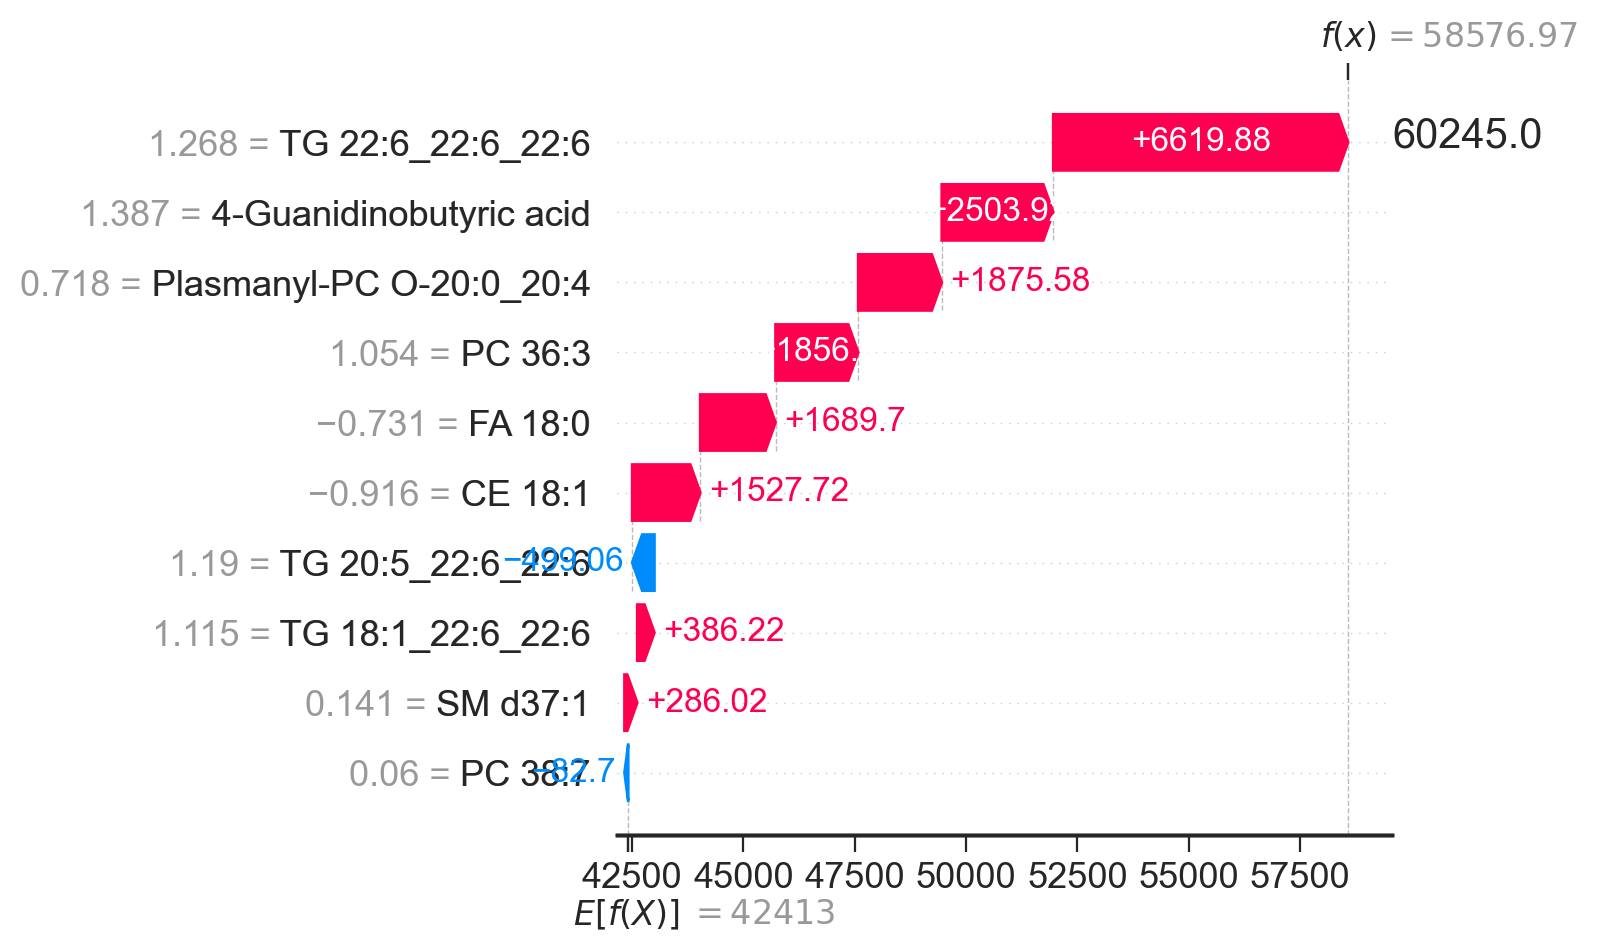

In [256]:
# for idx in range(len(y_ogtt)):

best_waterfall_plots = [2, 20, 23]
for idx in best_waterfall_plots:
    plt.figure()
    wf = shap.plots.waterfall(shap_values[idx], max_display=14, show=False)
    ax = plt.gca()
    ogtt_value = y_ogtt.iloc[idx]
    animal_label = ap.loc[ap['OGTT (AUC)'] == ogtt_value, 'Nile rat label'].values[0]
    ax.text(1, 0.9, ogtt_value, ha='left', va='bottom', transform=ax.transAxes, fontsize=15)
    wf.set_dpi(200)
    wf.set_size_inches(5, 5)
    print(idx, animal_label, idx%3 + 1)
#     plt.savefig(f'../reports/figures/Figure6/SHAP_waterfall_plots/rat{animal_label}_{idx%3 + 1}_waterfall.svg', dpi=300, bbox_inches='tight')
#     plt.close()

animal
1060    G
Name: Nile rat label, dtype: object


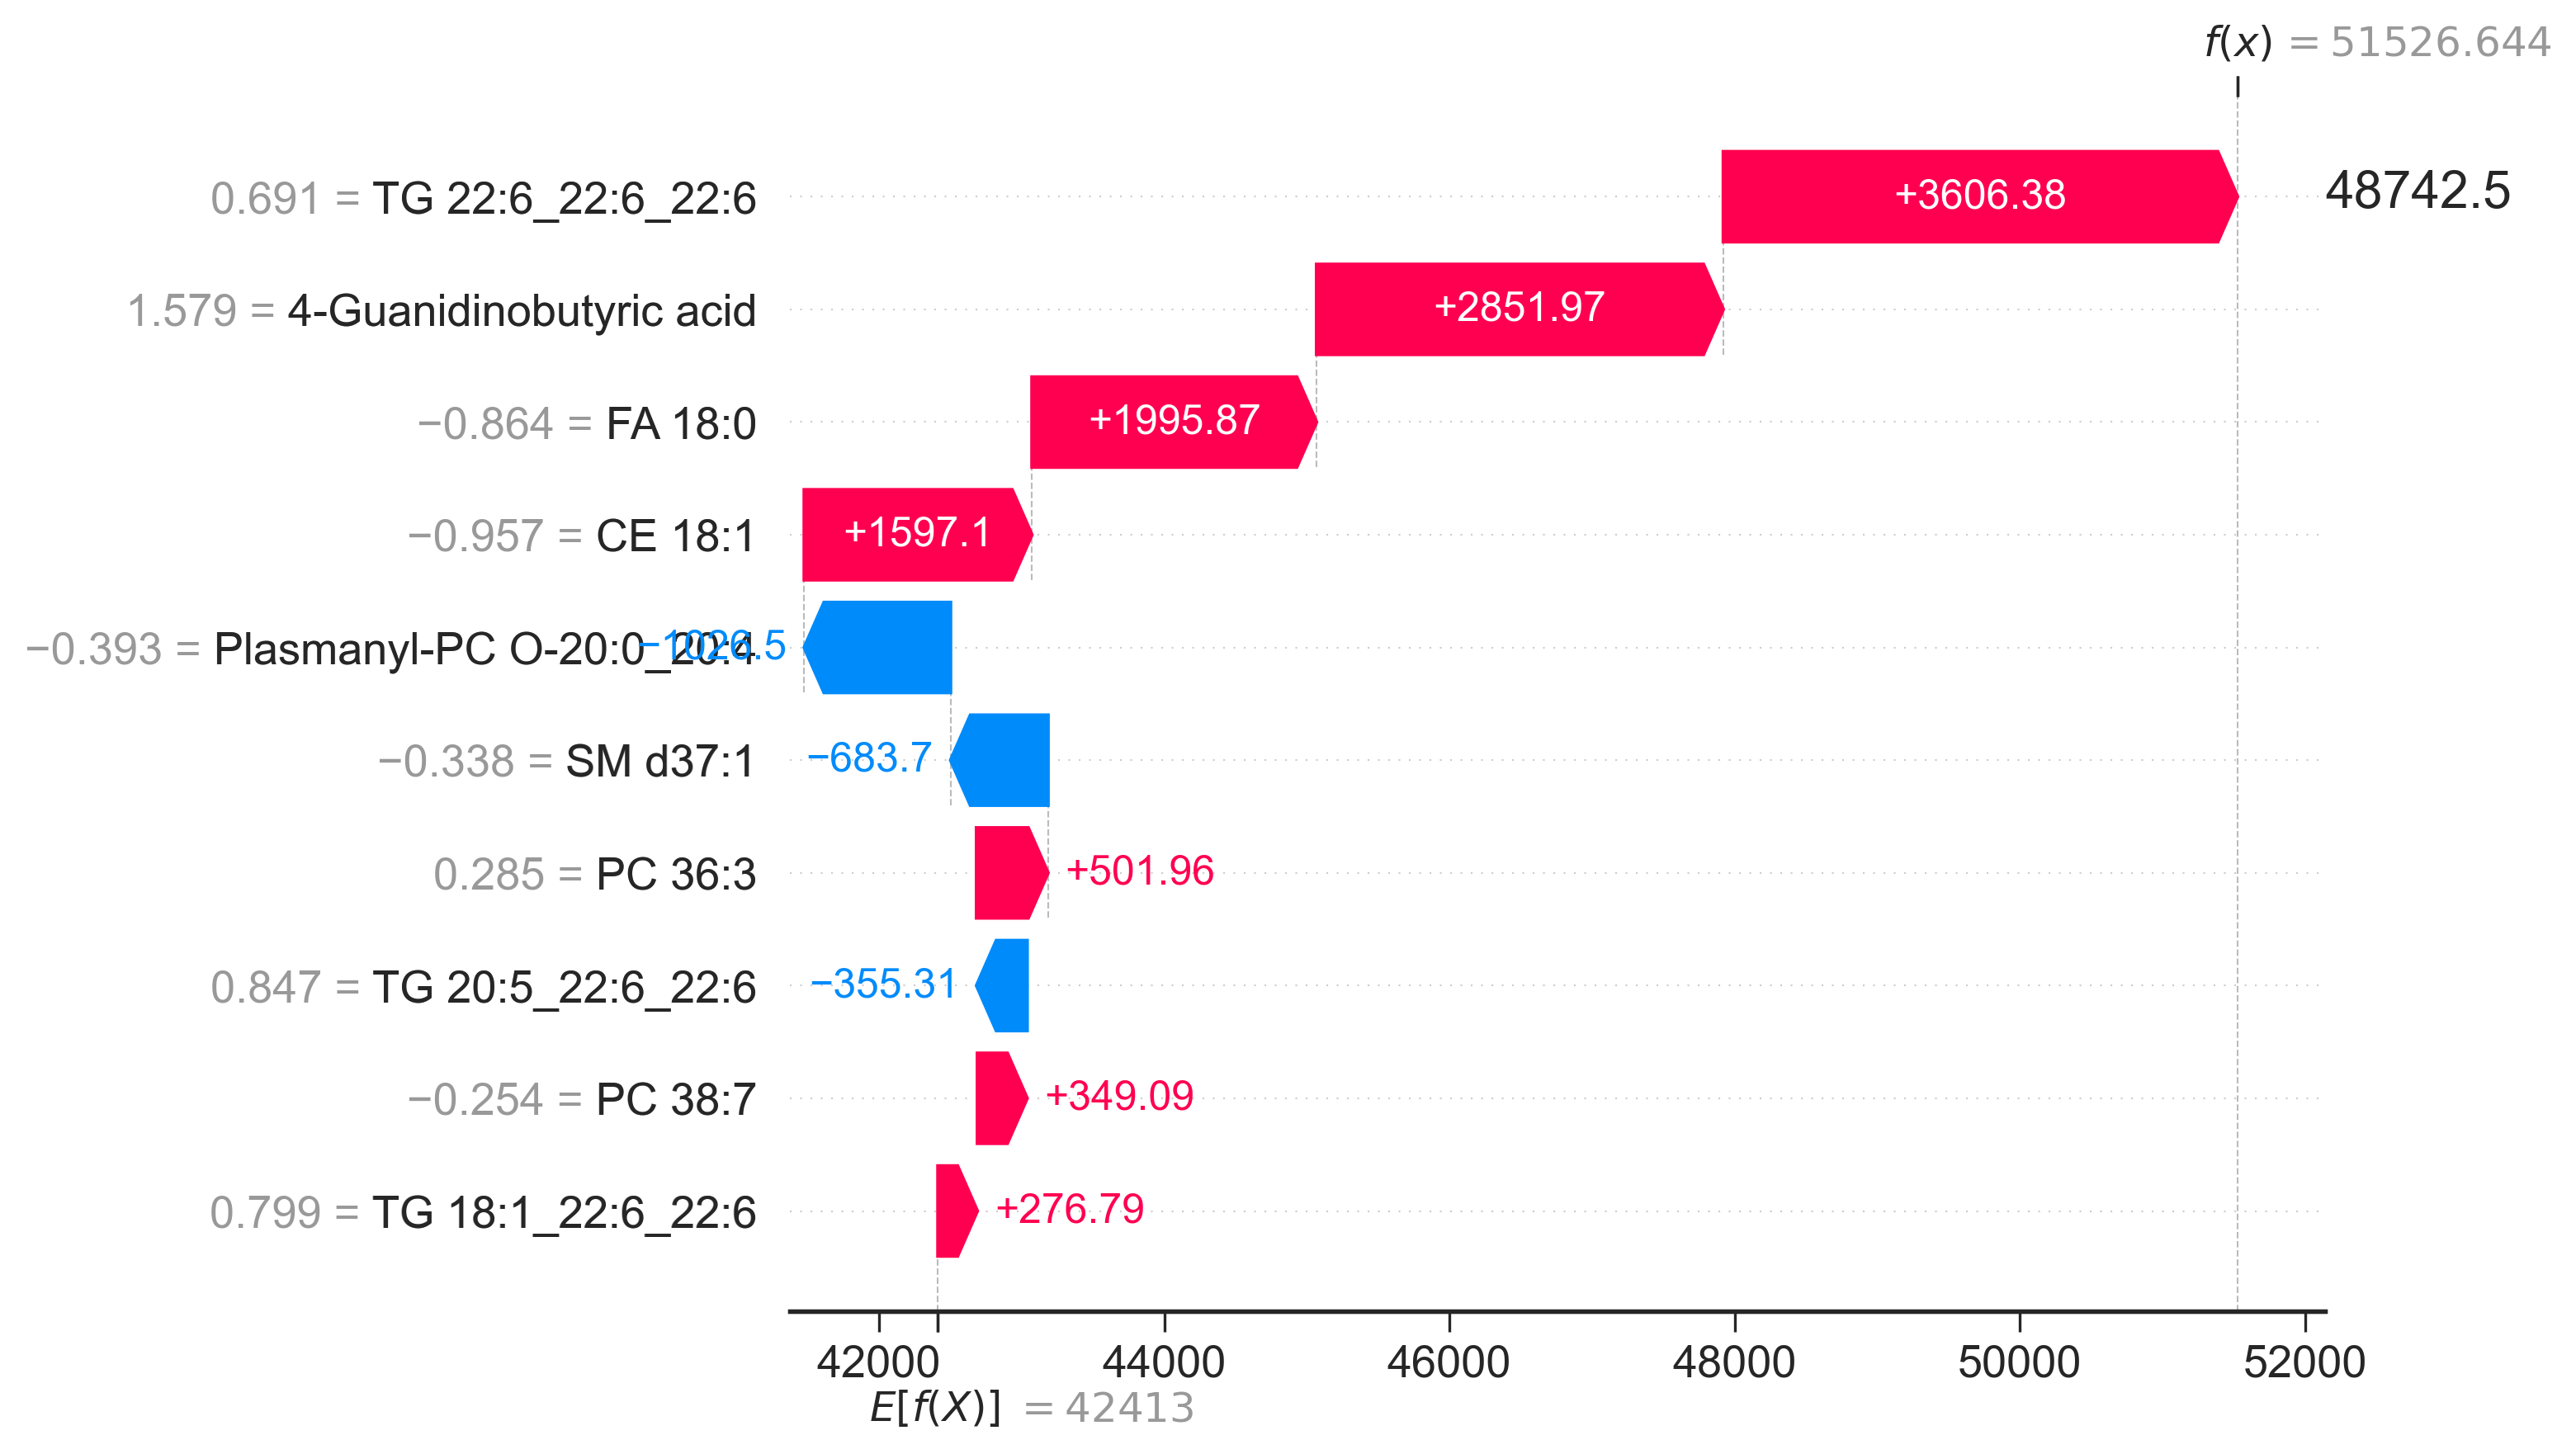

In [215]:
idx = 6

wf = shap.plots.wawterfall(shap_values[idx], max_display=14, show=False)
ax = plt.gca()
ogtt_value = y_ogtt.iloc[idx]
animal_label = ap.loc[ap['OGTT (AUC)'] == ogtt_value, 'Nile rat label']
print(animal_label)
ax.text(1, 0.9, ogtt_value, ha='left', va='bottom', transform=ax.transAxes, fontsize=15)
wf.set_dpi(300)

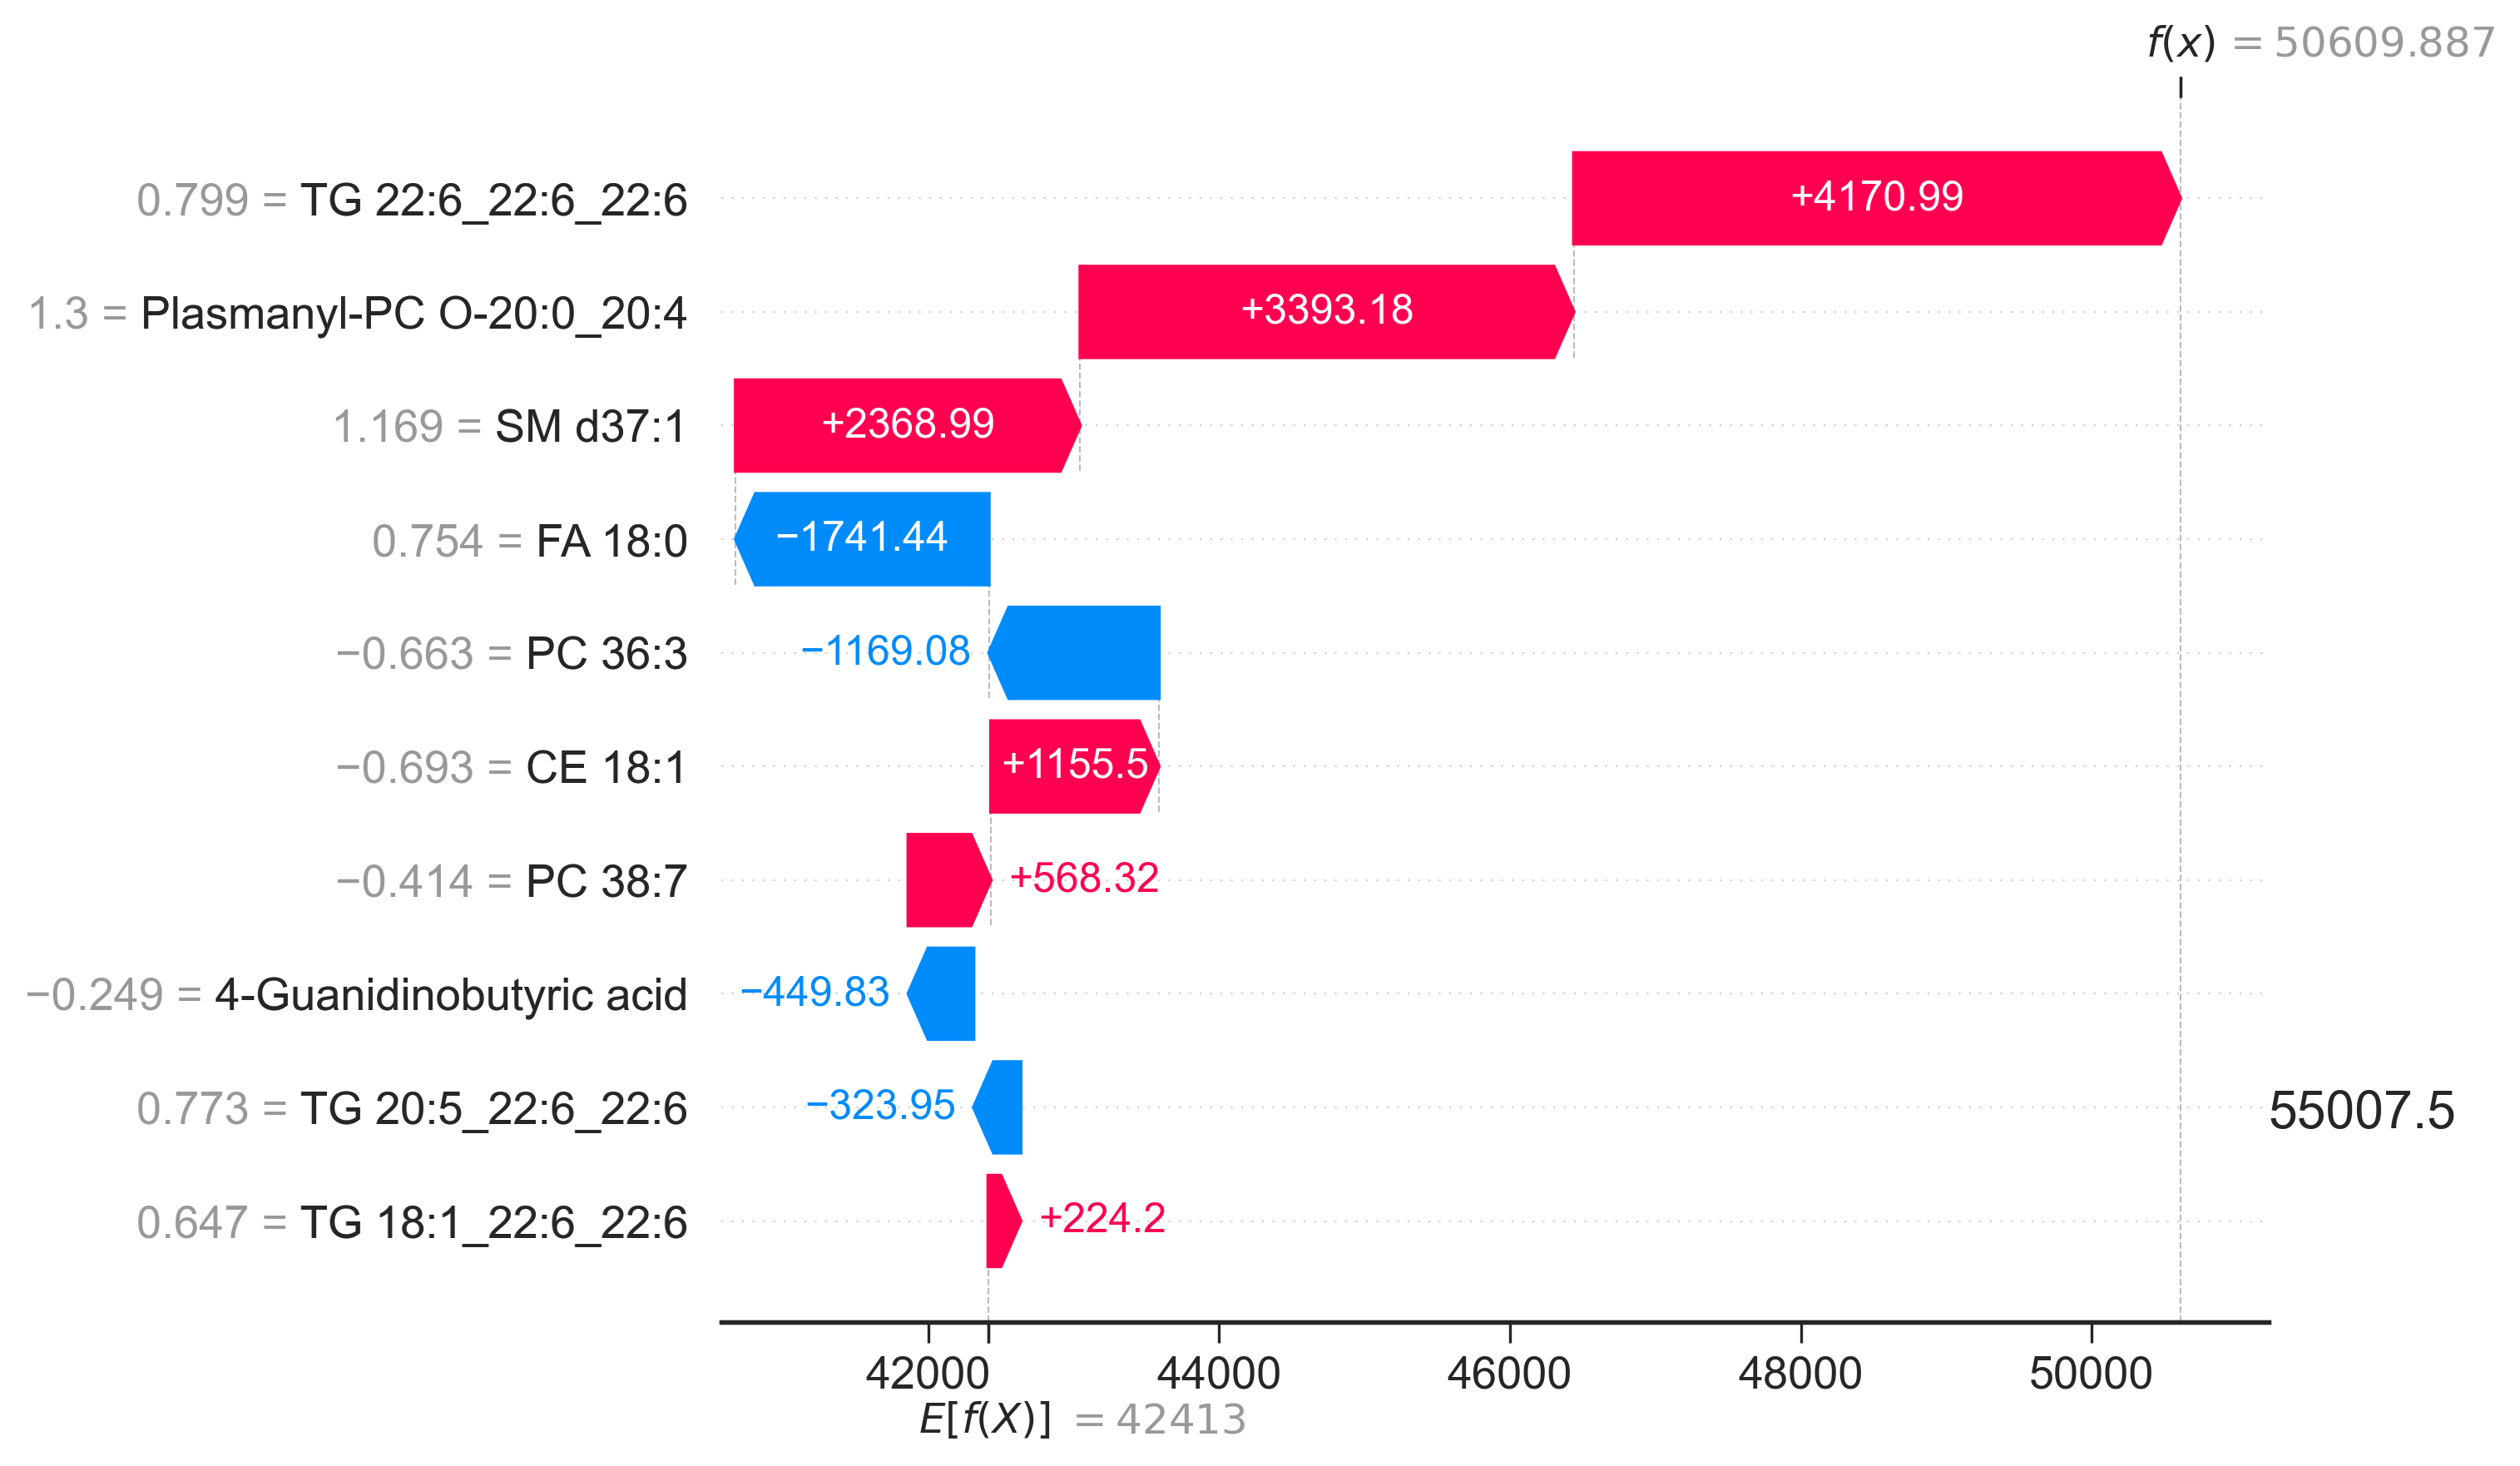

In [173]:
idx = 29

wf = shap.plots.waterfall(shap_values[idx], max_display=14, show=False)
ax = plt.gca()
ax.text(1, 0.15, y_ogtt.iloc[idx], ha='left', va='bottom', transform=ax.transAxes, fontsize=15)
wf.set_dpi(300)

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


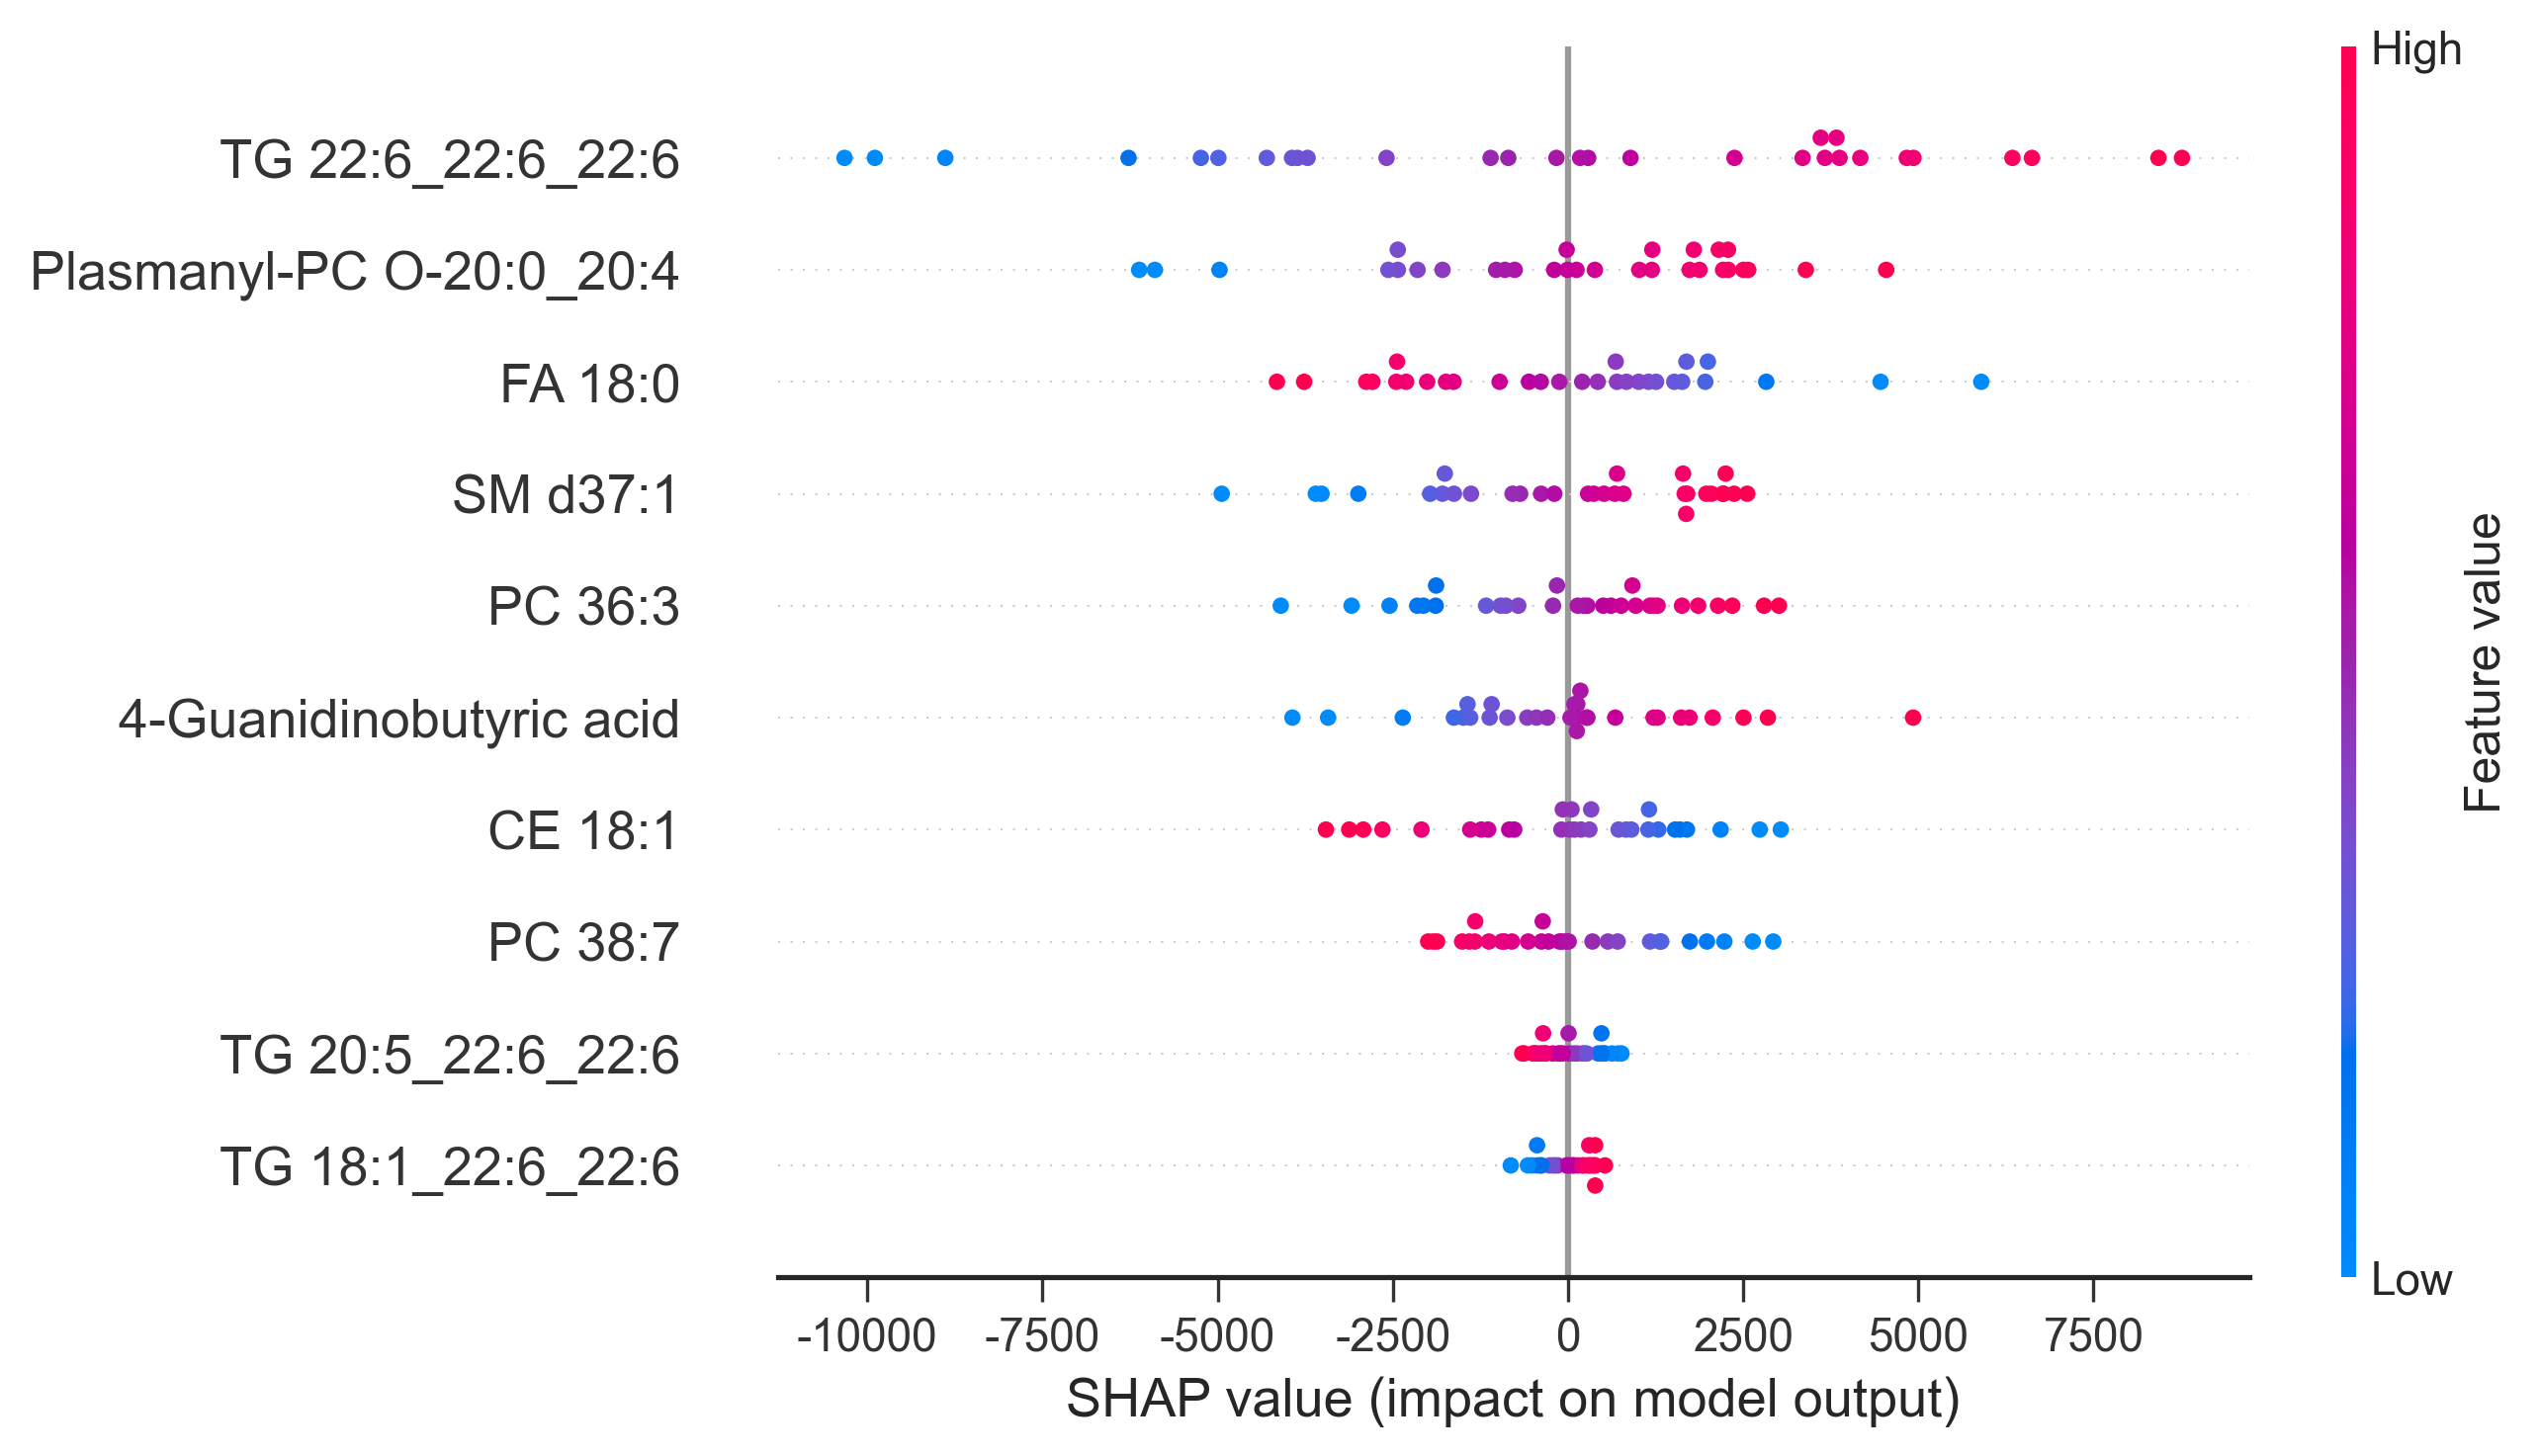

In [174]:
bs = shap.plots.beeswarm(shap_values, show=False, color_bar=True, )
fig = plt.gcf()
fig.set_dpi(300)
ax = plt.gca()
# ax.set_title('')
plt.savefig('../reports/figures/Figure6/SHAP_beeswarm_top_10_elastic_net.pdf', 
            dpi=300, bbox_inches='tight')

# Example of SHAP for linear regression from 
https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [47]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X_example, y_example = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X_example, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X_example, y_example)

LinearRegression()

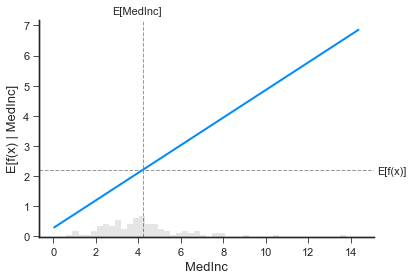

In [48]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

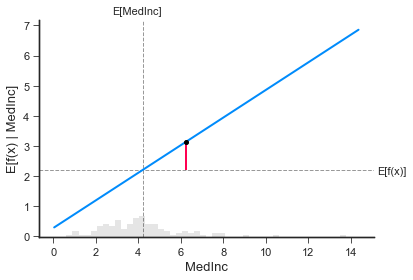

In [50]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X_example)
shap_values = explainer(X_example)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

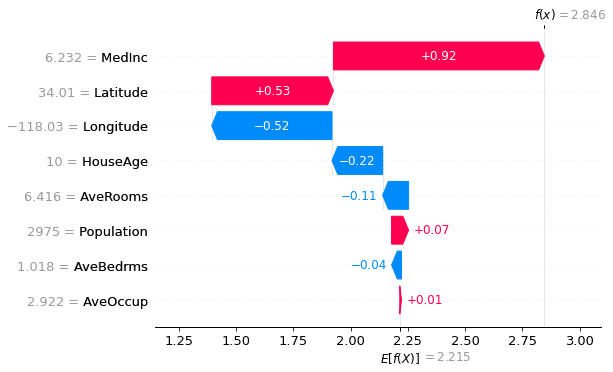

In [6]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

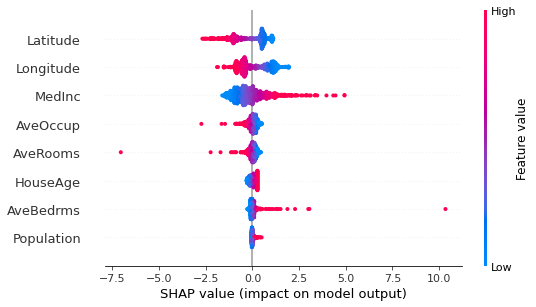

In [7]:
shap.plots.beeswarm(shap_values)